# Two layer perceptron 3.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, zero_one_loss

## Generating data

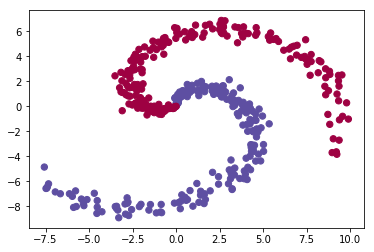

In [2]:
N = 200 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes
X = np.zeros((N*K,D))# data matrix (each row = single example)

#Creates targets
y = np.ones(N,dtype=np.int)
minus = -1 * np.ones(N,dtype=np.int)
y = np.append(y,minus)

#Generates the samples
np.random.seed(42)
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,10,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    #y[ix] = j

#Splits data in train/test-sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

#Lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [3]:
len(y_test)
np.shape(y_train)

(300,)

## General code for two layer perceptron

In [6]:
class neuralNet():
    def __init__(self,dim,nr1,nr2):
        self.nrOfInputs = dim 
        
        #Storing errors for each epoch to eventually plot a learning curve
        self.trainAbsErrors = []
        self.trainMseErrors = []
        self.testAbsErrors = []
        self.testMseErrors = []
        
        self.finalW = [] #Store weights when training is done
        self.shape_y = 0 #Nr of outputs, initially 0
        
        self.nrOfNodes_layer1 = nr1
        self.nrOfNodes_layer2 = nr2
    
    def initWeights(self,nrOfNeuronsInLayer,nrOfInputsPerNeuron):
        #Need to add one one weight for bias term
        np.random.seed(42)
        w = np.random.normal(0,1,size=(nrOfInputsPerNeuron+1,nrOfNeuronsInLayer))
        return w
    
    #Introduces non-linearity
    def transferFunc(self,x):
        transformed = 2/(1+np.exp(-x))-1
        return transformed

    def transferDerivative(self, x):
        derivative = np.multiply((1+x),(1-x))/2
        return derivative
    
    #Outputs activations in layer 1 for task 3.2.2
    def inspectActivation(self,patterns):
        w1 = self.finalW[0]
        w2 = self.finalW[1]
        hout,_ = self.forwardPass(patterns,w1,w2) 
        return hout[:,:3] #Exclude bias
        
    def predict(self,patterns):
        _,pred = self.forwardPass(patterns,self.finalW[0],self.finalW[1])
        pred[pred>=0]=int(1)
        pred[pred<0]=int(-1)
        return pred
    
    #Takes NxM-dimensional input, passes it throught the two layers and produces an output
    def forwardPass(self,patterns,w_1,w_2): 
        bias = np.ones(len(patterns),dtype=int)
        patterns = np.column_stack([patterns,bias])

        h_in = np.dot(patterns,w_1) #hin = w_1*[patterns + bias] (transposed)
        h_out = np.column_stack([self.transferFunc(h_in),bias]) #hout = [transferFunc(hin)+bias]  
        o_in = np.dot(h_out,w_2) #oin = w_2 * hout (transposed)
        print("oin:", o_in)
        o_out = self.transferFunc(o_in) #out = transferFunc(oin)
        
        return h_out,o_out
    
    #Backpropagates the error, calculating how each weight contributes to it
    def backPropagation(self,targets,h_out,o_out,w_2):
        targets = targets.reshape(targets.shape[0],self.shape_y)        
        delta_o = np.multiply((o_out-targets),self.transferDerivative(o_out))    
        delta_h = np.dot(delta_o,w_2.T)*self.transferDerivative(h_out)
        delta_h = delta_h[:,:self.nrOfNodes_layer1]
        return delta_h,delta_o
     
    #Calculates the rate of zero-one-loss and MSE of the predictions
    def calcError(self,pred,y,epochNr,traintest):
        mse = mean_squared_error(y,pred)
        
        #Thresholding
        pred[pred>=0]=1
        pred[pred<0]=-1
        zOloss = zero_one_loss(y,pred,normalize=True)
        
        #print("Nr of errors in",traintest,"data during epoch",epochNr,":",zOloss)
        return zOloss,mse
        
    #Update weights according to specified learning rate (eta) and alpha
    def update_weights(self,X,y,w_1,w_2,dw_1,dw_2,delta_h,delta_o,h_out):
        bias = np.ones(len(X),dtype=int)
        #updateWeights
        alpha=0.9
        eta=0.05
        dw_1 = np.multiply(dw_1,alpha)-np.dot(np.column_stack([X,bias]).T,delta_h)*(1-alpha)            
        dw_2 = np.multiply(dw_2,alpha)-np.dot(h_out.T,delta_o)*(1-alpha)
        w_1 = w_1 + dw_1*eta
        w_2 = w_2 + dw_2*eta

        return w_1,w_2,dw_1,dw_2
    
    #Trains a neural network using batch learning
    def train_batch(self,X,y,X_test,y_test,epochs):
        self.shape_y = int(y.size/len(y))
        w_1 = self.initWeights(self.nrOfNodes_layer1,self.nrOfInputs) #Weights for first layer
        w_2 = self.initWeights(self.nrOfNodes_layer2,self.nrOfNodes_layer1) #Weights for second layer
        dw_1 = 0
        dw_2 = 0
        
        bias = np.ones(len(X),dtype=int)
        for epoch in range(epochs):
            h_out,o_out = self.forwardPass(X,w_1,w_2) #Forward pass            
            delta_h,delta_o = self.backPropagation(y,h_out,o_out,w_2) #backPropagation
            w_1,w_2,dw_1,dw_2 = self.update_weights(X,y,w_1,w_2,dw_1,dw_2,delta_h,delta_o,h_out) #Update weights
    
            #Make a prediction on training data with the current weights
            _,predictions_train = self.forwardPass(X,w_1,w_2)
            train_abs, train_mse = self.calcError(predictions_train,y,epoch,"train")

            #Make a prediction on testing data with the current weights
            _,predictions_test = self.forwardPass(X_test,w_1,w_2) #calc error on testdata as well
            test_abs, test_mse = self.calcError(predictions_test,y_test,epoch,"test")

            #Store errors
            self.trainAbsErrors.append(train_abs)
            self.trainMseErrors.append(train_mse)
            self.testAbsErrors.append(test_abs)
            self.testMseErrors.append(test_mse)
        
        #Store final weights for later use
        self.finalW = [w_1,w_2]

    #Trains a neural network using sequential learning.
    #Could be merged with train_batch() if one where to enable dynamic
    #batch size
    def train_seq(self,patterns,targets,X_test,y_test,epochs):
        self.shape_y = int(targets.size/len(targets))
        w_1 = self.initWeights(self.nrOfNodes_layer1,self.nrOfInputs) #Weights for first layer
        w_2 = self.initWeights(self.nrOfNodes_layer2,self.nrOfNodes_layer1) #Weights for second layer
        dw_1 = 0
        dw_2 = 0
        
        bias = np.ones(len(patterns),dtype=int)
        for epoch in range(epochs):
            for i in range(targets.size):
                X = patterns[i].reshape(1,2)                
                y = np.array(targets[i])
                
                h_out,o_out = self.forwardPass(X,w_1,w_2) #Forward pass            
                delta_h,delta_o = self.backPropagation(y,h_out,o_out,w_2) #backPropagation
                w_1,w_2,dw_1,dw_2 = self.update_weights(X,y,w_1,w_2,dw_1,dw_2,delta_h,delta_o,h_out)

            #Make a prediction on training data with the current weights
            _,predictions_train = self.forwardPass(patterns,w_1,w_2)            
            train_abs, train_mse = self.calcError(predictions_train,targets,epoch,"train")

            #Make a prediction on testing data with the current weights
            _,predictions_test = self.forwardPass(X_test,w_1,w_2) #calc error on testdata as well
            test_abs, test_mse = self.calcError(predictions_test,y_test,epoch,"test")
          
            self.testAbsErrors.append(test_abs)
            self.testMseErrors.append(test_mse)
            self.trainAbsErrors.append(train_abs)
            self.trainMseErrors.append(train_mse)
        
        self.finalW = [w_1,w_2]
    
    #Plots the 0/1-loss and MSE for each epoch
    def evaluate(self,epochs):
        f,axarr = plt.subplots(2,sharex=True)
        axarr[0].plot(range(epochs),self.trainAbsErrors, '-',label="train")
        axarr[0].plot(range(epochs),self.testAbsErrors, '-',label="test")
        axarr[0].set_title('Ratio of misclassifications')
        
        axarr[1].plot(range(epochs),self.trainMseErrors, '-',label="train")
        axarr[1].plot(range(epochs),self.testMseErrors, '-',label="test")
        axarr[1].set_title('Mean squared error')
        
        plt.grid()
        plt.legend()
        plt.show()
        
    #Prints out the errors from thes final training epoch    
    def printErrors(self):
        print("Final misclassification ratio:",self.testAbsErrors[len(self.testAbsErrors)-1])
        print("Final MSE:",self.testMseErrors[len(self.testMseErrors)-1])        

## Experiments for 3.2.1
### First we experiment with a 2-4-1 setting...

oin: [[ 1.865724  ]
 [-1.05043114]
 [ 2.03058845]
 [-2.0276269 ]
 [-0.28221545]
 [ 2.45903415]
 [ 1.98001733]
 [ 1.64004257]
 [ 1.07103789]
 [ 1.1953125 ]
 [-1.5068348 ]
 [-2.50337021]
 [ 1.64536647]
 [ 1.50590691]
 [ 1.5975474 ]
 [ 1.95654462]
 [-2.06294977]
 [ 1.76081461]
 [-2.59482722]
 [ 0.88061985]
 [-2.01554649]
 [ 1.74780071]
 [ 1.04685277]
 [ 1.97984901]
 [ 0.82370158]
 [ 1.57541613]
 [ 1.85528838]
 [-2.81547846]
 [-2.27399215]
 [ 1.76078381]
 [-0.42612925]
 [-1.20489142]
 [ 2.43962353]
 [-1.6327896 ]
 [ 2.01429671]
 [ 2.01592612]
 [ 2.13997734]
 [-2.56295828]
 [-2.26626944]
 [ 0.46569883]
 [ 1.83490903]
 [ 1.23559312]
 [-0.239982  ]
 [-2.60132693]
 [ 2.40957725]
 [ 2.09119321]
 [ 1.54990604]
 [-2.06280848]
 [-2.45026535]
 [ 1.54422506]
 [ 2.22805063]
 [-0.86659551]
 [-2.20857522]
 [ 1.64100146]
 [-0.62221701]
 [ 1.89179909]
 [ 0.20845541]
 [-2.30319729]
 [ 0.22001396]
 [ 0.25870649]
 [ 2.05563723]
 [ 2.45977746]
 [-2.76904206]
 [-2.96122288]
 [ 0.53453109]
 [ 2.1357259 ]
 [-1.

oin: [[-2.30746780e+00]
 [ 1.42469564e+00]
 [-1.42547889e+00]
 [ 3.43998845e+00]
 [ 1.67194755e+00]
 [-1.43246957e+00]
 [-1.71282010e+00]
 [-2.14491358e+00]
 [ 5.23689920e+00]
 [-1.11626817e+00]
 [-4.28620034e-02]
 [ 3.11829922e+00]
 [-2.01973040e+00]
 [ 8.09862389e-01]
 [ 2.93928218e+00]
 [ 1.26044237e+00]
 [-4.64300075e-01]
 [-2.29485449e+00]
 [ 3.11375661e+00]
 [ 6.45152596e+00]
 [-2.56671911e+00]
 [-1.39378950e-01]
 [ 5.47588474e+00]
 [-7.54673354e-02]
 [-1.20148650e+00]
 [-2.07307714e+00]
 [ 1.95290846e-03]
 [ 2.20044209e+00]
 [ 3.11539168e+00]
 [-2.24998354e+00]
 [ 1.66329156e+00]
 [-3.42241071e+00]
 [-1.43598965e+00]
 [-4.24706800e-01]
 [-6.26384098e-01]
 [-8.55264404e-02]
 [-1.14564428e-01]
 [ 3.11458491e+00]
 [-1.67743767e+00]
 [ 7.57502964e+00]
 [-2.38066938e+00]
 [-1.20594056e+00]
 [ 1.94490082e+00]
 [ 3.11217126e+00]
 [-1.43752142e+00]
 [-5.34219477e-02]
 [ 4.04449322e+00]
 [ 3.24528032e+00]
 [-7.69520106e-01]
 [ 6.51382088e-01]
 [-1.43251706e+00]
 [-3.69248816e+00]
 [ 3.09

oin: [[-6.23449888]
 [-0.74192629]
 [-3.33932019]
 [ 5.70721614]
 [ 2.86226569]
 [-3.34323617]
 [-3.61179543]
 [-6.70247086]
 [ 7.40744342]
 [-3.47357846]
 [-2.94103835]
 [ 5.53388841]
 [-6.38967928]
 [ 5.25667358]
 [-0.72331518]
 [ 3.64183125]
 [-4.03452415]
 [-6.87145156]
 [ 5.50340591]
 [ 9.62469645]
 [-5.16380992]
 [ 2.51028887]
 [ 7.25028673]
 [ 3.06955969]
 [-5.76863769]
 [-6.62550799]
 [ 3.29590575]
 [ 1.93672897]
 [ 5.53504812]
 [-6.79441331]
 [ 2.20441632]
 [-5.51507019]
 [-3.3458969 ]
 [-3.38418753]
 [ 0.4166671 ]
 [ 2.81227261]
 [ 1.17319342]
 [ 5.52061682]
 [-4.80115273]
 [13.59877819]
 [-6.80509473]
 [-3.86518466]
 [ 3.90021626]
 [ 5.49317066]
 [-3.3465155 ]
 [ 1.95626215]
 [ 5.22058962]
 [ 5.58727931]
 [-4.33633606]
 [ 4.92469111]
 [-3.34542002]
 [-5.71467939]
 [ 5.53486688]
 [ 5.11175887]
 [-6.65211301]
 [-5.29983519]
 [14.04019117]
 [ 5.53504864]
 [ 3.52669614]
 [ 4.15675907]
 [-3.35750818]
 [-3.34580564]
 [-2.05784998]
 [ 1.88780262]
 [-7.80374013]
 [-3.34317955]
 [-2.

oin: [[-5.49454688e+00]
 [-3.89047100e-01]
 [-3.56191740e+00]
 [ 1.63257438e+01]
 [ 3.01585652e+00]
 [-3.67272840e+00]
 [-3.70433645e+00]
 [-6.86569773e+00]
 [ 7.98493559e+00]
 [-4.62620479e+00]
 [-3.20110500e+00]
 [ 7.87935262e+00]
 [-5.58030152e+00]
 [ 7.18578938e+00]
 [-2.66581998e+00]
 [ 4.89625082e+00]
 [-5.04861291e+00]
 [-8.05792600e+00]
 [ 7.51250273e+00]
 [ 9.94936459e+00]
 [-6.25235058e+00]
 [ 5.66517089e+00]
 [ 7.96291474e+00]
 [ 5.06625074e+00]
 [-7.41747775e+00]
 [-6.11579110e+00]
 [ 5.79864780e+00]
 [ 2.72845888e+00]
 [ 7.89594848e+00]
 [-7.65766585e+00]
 [ 2.35316735e+00]
 [-6.32420331e+00]
 [-3.67532556e+00]
 [-3.83743890e+00]
 [ 2.94322570e+00]
 [ 4.64104812e+00]
 [ 2.23713130e+00]
 [ 7.75345747e+00]
 [-6.06832197e+00]
 [ 1.51317042e+01]
 [-7.30556907e+00]
 [-4.37654256e+00]
 [ 4.43750564e+00]
 [ 7.41785511e+00]
 [-3.67614268e+00]
 [ 3.33197140e+00]
 [ 5.73812906e+00]
 [ 1.44971160e+01]
 [-5.88646011e+00]
 [ 7.03165746e+00]
 [-3.67220695e+00]
 [-6.36516751e+00]
 [ 7.89

oin: [[-4.32663617]
 [-0.88822711]
 [-4.21856756]
 [16.44410906]
 [ 3.43655763]
 [-4.40587082]
 [-4.36656032]
 [-6.9796274 ]
 [ 7.72174312]
 [-3.05974016]
 [-4.12516569]
 [ 6.57069734]
 [-5.41706181]
 [ 6.95884345]
 [-1.8606042 ]
 [ 5.49093545]
 [-6.00302394]
 [-5.81801292]
 [ 3.70568852]
 [ 9.17036164]
 [-7.00183386]
 [ 5.77912421]
 [ 7.66119542]
 [ 5.47239019]
 [-7.98997868]
 [-6.28998132]
 [ 5.92098522]
 [ 3.22494716]
 [ 8.19731333]
 [-5.26112119]
 [ 2.67233933]
 [-7.08037301]
 [-4.41267099]
 [-4.77904074]
 [ 3.57263234]
 [ 5.18394891]
 [ 3.32685613]
 [ 4.87749229]
 [-6.81921205]
 [14.68424852]
 [-4.53281138]
 [-2.77978646]
 [ 4.68049344]
 [ 3.64448618]
 [-4.41471087]
 [ 4.22771217]
 [ 6.23414939]
 [13.62252054]
 [-6.64477266]
 [ 6.84617999]
 [-4.40733418]
 [-7.12050887]
 [ 8.19338433]
 [ 6.271959  ]
 [-7.25492852]
 [-4.23045596]
 [16.61535752]
 [ 8.19645891]
 [ 4.42245395]
 [ 5.22912999]
 [-4.36682489]
 [-4.41276059]
 [-5.70845688]
 [ 3.2248598 ]
 [-7.822951  ]
 [-4.38601751]
 [-3.

oin: [[15.63714117]
 [-7.71253127]
 [-7.85392196]
 [-4.30276786]
 [-4.567283  ]
 [ 8.39936638]
 [16.71698534]
 [ 4.77012862]
 [-4.56192483]
 [-7.47045239]
 [-4.55627243]
 [ 5.75334996]
 [ 8.50983284]
 [ 9.66895636]
 [ 5.34177581]
 [ 8.42035678]
 [ 6.64956233]
 [-7.60044974]
 [-4.55257677]
 [ 2.13579448]
 [ 6.93890237]
 [ 0.610005  ]
 [ 6.54372819]
 [-7.32983414]
 [-6.51385039]
 [ 6.39786543]
 [-7.68730339]
 [-7.85695239]
 [-7.7150714 ]
 [18.27457337]
 [14.65318728]
 [-5.73088207]
 [-7.22066705]
 [ 6.38133699]
 [-7.57728664]
 [ 5.85663537]
 [-4.56631954]
 [-5.11806382]
 [18.29846999]
 [ 4.81746517]
 [-7.75116344]
 [-4.52169572]
 [ 6.69390974]
 [16.72764225]
 [ 1.21539077]
 [ 7.53341579]
 [-2.20741936]
 [-7.61526574]
 [ 3.20982314]
 [-4.50001115]
 [-1.99590722]
 [-6.45671616]
 [ 6.16954948]
 [ 3.20983241]
 [ 6.57579953]
 [-4.5486597 ]
 [ 5.67352418]
 [-7.57118486]
 [ 3.20984493]
 [ 6.97618518]
 [10.41909212]
 [12.50583726]
 [ 5.53542254]
 [17.83889247]
 [ 3.4462637 ]
 [ 4.64832163]
 [-4.

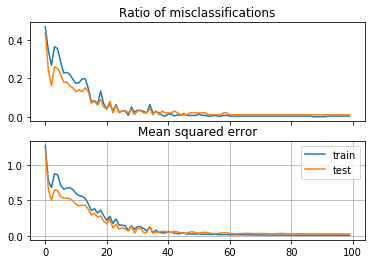

Final misclassification ratio: 0.010000000000000009
Final MSE: 0.03125625162690306


In [7]:
#BATCH LEARNING

nodesInFirstLayer=4
nodesInSecondLayer=1
nrOfInputs=2
epochs = 100

nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_batch(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()


In [6]:
#SEQUENTIAL LEARNING

nodesInFirstLayer=4
nodesInSecondLayer=1
nrOfInputs=2
epochs = 100

nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_seq(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()

IndexError: tuple index out of range

### Next we try a 2-16-1 set-up to see if there's any difference

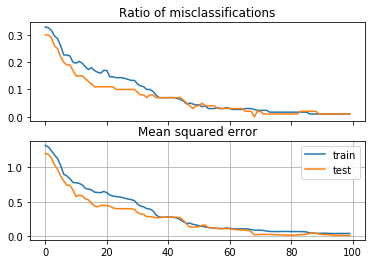

Final misclassification ratio: 0.010000000000000009
Final MSE: 0.017223900554313394


In [7]:
#BATCH LEARNING
nodesInFirstLayer=128
nodesInSecondLayer=1
epochs = 100
nrOfInputs=2

nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_batch(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()

In [8]:
#SEQUENTIAL LEARNING

nodesInFirstLayer=128
nodesInSecondLayer=1
nrOfInputs=2
epochs = 100


nn = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn.train_seq(X_train,y_train,X_test,y_test,epochs)
nn.evaluate(epochs)
nn.printErrors()

IndexError: tuple index out of range

In [9]:
node_array1=[1,2,4,8,16,32,64,128]
nodesInSecondLayer=1
for node1 in node_array1:
    print("Nr of nodes in 1st layer:",node1)
    nn = neuralNet(2,node1,nodesInSecondLayer)
    nn.train_seq(X_train,y_train,X_test,y_test,100)
    nn.printErrors()
    nn=0
    print("\n")

Nr of nodes in 1st layer: 1


IndexError: tuple index out of range

## Experiments for 3.2.2
The encoding problem. Set up network with 8-3-8 structure

In [10]:
#Generates random 1x8 vectors for testing
def generateAutoData(nr):
    np.random.seed(42)
    X_auto = []
    for i in range(nr):
        index = np.random.randint(8)-1
        one8 = -1*np.ones(8, dtype=int)
        one8[index]=1
        X_auto.append(one8)
    return np.array(X_auto)

#Generates the 8-unique representations of a one-hot-encoded 1x8 vector
def genTrainData():
    X_train=[]
    for i in range(8):
        one8 = -1*np.ones(8, dtype=int)
        one8[i]=1
        X_train.append(one8)
    return np.array(X_train)
        
X_auto_train = genTrainData()
X_auto_test = generateAutoData(50)


In [11]:
#Some examples
print(X_auto_train[0])
print(X_auto_train[7])

[ 1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1  1]


In [12]:
#TRAIN AND TEST NETWORK WITH SAME DATA
nrOfInputs = 8
nodesInFirstLayer=3
nodesInSecondLayer=8
epochs = 750

nn_3 = neuralNet(nrOfInputs,nodesInFirstLayer,nodesInSecondLayer) 
nn_3.train_batch(X_auto_train,X_auto_train,X_auto_test,X_auto_test,epochs)

Final misclassification ratio: 0.0
Final MSE: 0.060023916214828055


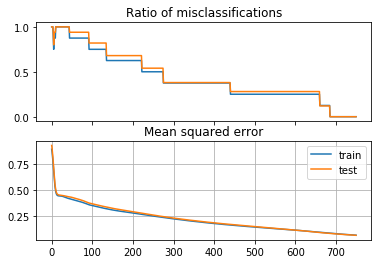

In [13]:
nn_3.printErrors()
nn_3.evaluate(epochs)

In [14]:
ind = range(33,43)
pred = nn_3.predict(X_auto[ind])
for i in ind:
    print("Sample:",X_auto[i])
    print("Predict:",pred[i-33],"\n")


NameError: name 'X_auto' is not defined

1st layer Weights:
 [[-0.36615866  0.95126467  1.50701715]
 [ 2.14606898  0.32625851  1.26280609]
 [ 1.50883771  1.67264209 -1.08487314]
 [ 1.95613378 -0.6266048  -0.78497075]
 [-0.99953566  0.50497275 -1.26592545]
 [-0.90329576 -2.22846349 -0.79427928]
 [-0.8202609  -1.52567908  1.8980173 ]
 [-0.33192514 -0.75302399 -3.00681105]
 [-0.46146158 -0.33251977 -1.0880608 ]] 

Activation: [-0.97709248 -0.91467318 -0.20102464]
Activation: [ 0.18115318  0.98181908 -0.4576969 ]
Activation: [ 0.55837632  0.0464186  -0.19207579]
Activation: [-0.97709248 -0.91467318 -0.20102464]
Activation: [0.6752908  0.76130645 0.9520544 ]
Activation: [-0.97300996 -0.69243694  0.9863049 ]
Activation: [ 0.55837632  0.0464186  -0.19207579]
Activation: [ 0.55837632  0.0464186  -0.19207579]
Activation: [-0.97709248 -0.91467318 -0.20102464]
Activation: [-0.93437883  0.92524863  0.97030581]


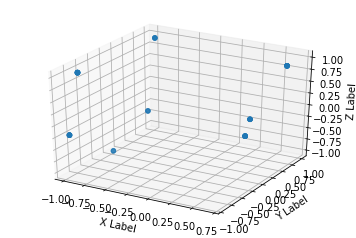

In [15]:
from mpl_toolkits.mplot3d import Axes3D

print("1st layer Weights:\n",nn_3.finalW[0],"\n")
activations = nn_3.inspectActivation(X_auto_test)
for i in range(10):
    print("Activation:",activations[i])

    
    
fig = plt.figure()
ax5 = fig.add_subplot(111,projection='3d')
#for c,m in [('r','o'),('b','^')]:
ax5.scatter(activations[:,0],activations[:,1],activations[:,2])
    
ax5.set_xlabel('X Label')
ax5.set_ylabel('Y Label')
ax5.set_zlabel('Z Label')
plt.show() 